# Fertility Contagion Model using AgentPy

An agent-based model that simulates the propagation of fertility through a network.

In [1666]:
# Import libraries.

# Data preprocessing.
import pandas as pd
from scipy import interpolate
import statsmodels.api as sm
from sklearn.impute import KNNImputer

# Model design.
import agentpy as ap
import networkx as nx
import numpy as np

# Visualization.
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preprocessing

Get numerical values from Pairfam dataset.

In [1667]:
# Load data from CSV.
pf_1 = pd.read_csv("../data/processed/fert_anchor_1.csv")
pf_2 = pd.read_csv("../data/processed/fert_anchor_2.csv")
pf_3 = pd.read_csv("../data/processed/fert_anchor_3.csv")
pf_4 = pd.read_csv("../data/processed/fert_anchor_4.csv")
pf_5 = pd.read_csv("../data/processed/fert_anchor_5.csv")
pf_6 = pd.read_csv("../data/processed/fert_anchor_6.csv")
pf_7 = pd.read_csv("../data/processed/fert_anchor_7.csv")
pf_8 = pd.read_csv("../data/processed/fert_anchor_8.csv")

In [1668]:
def filter_rel(df):

    # Filter out respondents without partners.
    df = df.dropna(subset="pid")

    # Filter out respondents without relationship status.
    df = df.dropna(subset="relstat")

    # Filter out anchors without cohabitation.
    # df = df[df["relstat"].str.contains("COHAB")]

    # Filter out anchors who are homosexual or are infertile.
    df = df[df["homosex_new"] == "0 Hetero"]
    df = df[df["infertile"] == "0 Fertile"]

    return df

In [1669]:
def scale_items_5(df):
    """ Scale questions with 5 items scale. """

    # Change all values to strings.
    df = df.astype(str)

    # Get the first character in the string (the numerical value of the response).
    df = df.apply(lambda x: x.str[0])

    # Replace nan and 7 with NaN.
    df = df.replace({"7": np.nan, "n": np.nan})

    # Covert columns to float.
    df = df.astype("float")

    # Normalize values.
    df = df.apply(lambda x: (x - 1) / 4)

    return df

In [1670]:
def convert_items_num(df):
    """ Convert responses to numeric. """

    # Change all values to strings.
    df = df.astype(str)

    # Get the first character in the string (the numerical value of the response).
    df = df.apply(lambda x: x.str[0])

    # Replace nan and 7 with NaN
    df = df.replace({"n": np.nan})

    # Covert columns to float.
    df = df.astype("float")

    return df

In [1671]:
def create_value_children(df):

    # Transform variables to integer.
    colnames_1 = [
        "bce2i1",
        "bce2i5",
        "bce2i2",
        "bce2i3",
        "bce2i4"
    ]

    colnames_2 = [
        "bce2i6",
        "bce2i8",
        "bce2i7",
        "bce2i9",
        "bce2i10"
    ]

    df[colnames_1 + colnames_2] = scale_items_5(df[colnames_1 + colnames_2])

    # Value of Children.
    value_children_positive = df[colnames_1].mean(axis = 1)

    value_children_negative = df[colnames_2].mean(axis = 1)

    df["value_children"] = (value_children_positive - value_children_negative).apply(lambda x: round(x, 2))

    return df

In [1672]:
def create_social_pressure(df):

    # Transform variables to integer.
    colnames_1 = [
        "frt10i1",
        "frt10i2"
    ]

    colnames_2 = [
        "frt10i3",
        "frt10i4"
    ]

    df[colnames_1 + colnames_2] = scale_items_5(df[colnames_1 + colnames_2])

    # Social pressure (p).
    social_pressure_positive = df[colnames_1].mean(axis = 1)

    social_pressure_negative = df[colnames_2].mean(axis = 1)

    df["social_pressure"] = (social_pressure_positive - social_pressure_negative).apply(lambda x: round(x, 2))

    return df

In [1673]:
def create_social_support(df):

    # Transform variables to integer.
    colnames = [
        "frt20i1",
        "frt20i2",
        "frt20i3"
    ]

    df[colnames] = scale_items_5(df[colnames])

    # Social support (s).
    social_support = df[colnames].mean(axis = 1)

    df["social_support"] = social_support.apply(lambda x: round(x, 2))

    return df

In [1674]:
def create_emotional_autonomy(df):

    # Transform variables to integer.
    colnames = [
        "per1i1",
        "per1i5",
        "per1i10"
    ]

    df[colnames] = scale_items_5(df[colnames])

    # Emotional autonomy.
    emotional_autonomy_rev = df[colnames].mean(axis = 1)

    df["emotional_autonomy"] = (1 - emotional_autonomy_rev).apply(lambda x: round(x, 2))

    return df

In [1675]:
def create_births(df1, df2):
    """Create a binary variable measuring births from one wave to another. """

    ref = df1[df1["id"].isin(df2["id"])].sort_values(by = ["id"])
    diff = df2[df2["id"].isin(ref["id"])].sort_values(by = ["id"])
    ref["birth"] = diff["nkidsbio"].values - ref["nkidsbio"].values
    ref["birth"] = ref["birth"].apply(lambda x: 1 if x>0 else 0)

    return ref

In [1676]:
def create_intention(df):
    """ Create concrete intention to procreate. """

    df["intention"] = df["frt7"].apply(lambda x: 1 if x in ["1 Yes, definitely", "2 Yes, perhaps"] else 0)

    return df

In [1677]:
def select_age(df):
    """ Select age according to sex (always the mother). """
    
    df.loc[(df["sex_gen"] == 1) & (df["page"].isnull().apply(lambda x: not x)), "age"] = df.loc[df["sex_gen"] == 1, "page"]

    return df

In [1678]:
def rolling_ratio_age(df, age, width, nkids = None):
    """ Calculate ratios of birth for conditional probability. """

    df_age = df[(df["age"] >= (age - width)) & (df["age"] <= (age + width))]

    if nkids:
        if nkids < 3:
            df_age_nkids = df_age[df_age["nkidsbio"] == nkids]
        else:
            df_age_nkids = df_age[df_age["nkidsbio"] >= nkids]
    else:
        df_age_nkids = df_age
        
    # Probability of certain nkids and age.
    prob_B = df_age_nkids.shape[0] / df.shape[0]
    
    # Probability of certain nkids and age and new child.
    prob_A_and_B = df_age_nkids[df_age_nkids["birth"] == 1].shape[0] / df.shape[0]
    
    # Conditional probability.
    if prob_B == 0 or df_age_nkids.shape[0] < 10:
        ratio = 0
    else:
        ratio = prob_A_and_B / prob_B
    
    return ratio

In [1679]:
def rolling_ratio_voc(df, voc, width):
    """ Calculate ratios of birth for conditional probability. """

    df_voc = df[(df["value_children"] >= (voc - width)) & (df["value_children"] <= (voc + width))]
        
    # Probability of certain VoC.
    prob_B = df_voc.shape[0] / df.shape[0]
    
    # Probability of certain VoC and Intention.
    prob_A_and_B = df_voc[df_voc["intention"] == 1].shape[0] / df.shape[0]
    
    # Conditional probability.
    if prob_B == 0 or df_voc.shape[0] < 10:
        ratio = 0
    else:
        ratio = prob_A_and_B / prob_B
    
    return ratio

In [1680]:
# Filter out respondents without partners.
agents_1 = filter_rel(pf_1)
agents_2 = filter_rel(pf_2)
agents_3 = filter_rel(pf_3)
agents_4 = filter_rel(pf_4)
agents_5 = filter_rel(pf_5)
agents_6 = filter_rel(pf_6)
agents_7 = filter_rel(pf_7)
agents_8 = filter_rel(pf_8)

In [1681]:
# Create new variables for simulation.
agents_1 = create_value_children(agents_1)
agents_1 = create_emotional_autonomy(agents_1)

agents_2 = create_value_children(agents_2)
agents_2 = create_social_pressure(agents_2)
agents_2 = create_social_support(agents_2)

agents_4 = create_value_children(agents_4)
agents_4 = create_social_pressure(agents_4)
agents_4 = create_social_support(agents_4)

agents_5 = create_emotional_autonomy(agents_5)

agents_6 = create_value_children(agents_6)
agents_6 = create_social_pressure(agents_6)
agents_6 = create_social_support(agents_6)

agents_8 = create_value_children(agents_8)
agents_8 = create_social_pressure(agents_8)
agents_8 = create_social_support(agents_8)

In [1682]:
# Create intention.
agents_1 = create_intention(agents_1)
agents_2 = create_intention(agents_2)
agents_3 = create_intention(agents_3)
agents_4 = create_intention(agents_4)
agents_5 = create_intention(agents_5)
agents_6 = create_intention(agents_6)
agents_7 = create_intention(agents_7)
agents_8 = create_intention(agents_8)

In [1683]:
# Get only interesting variables for simulation.
vars_gen = [
    "id", 
    "pid", 
    "wave",
    "age", 
    "page", 
    "sex_gen",
    "psex_gen",
    "nkidsbio", 
    "intention"
]

agents_1 = agents_1[vars_gen + ["value_children", "emotional_autonomy"]]
agents_2 = agents_2[vars_gen + ["value_children", "social_pressure", "social_support"]]
agents_3 = agents_3[vars_gen]
agents_4 = agents_4[vars_gen + ["value_children", "social_pressure", "social_support"]]
agents_5 = agents_5[vars_gen + ["emotional_autonomy"]]
agents_6 = agents_6[vars_gen + ["value_children", "social_pressure", "social_support"]]
agents_7 = agents_7[vars_gen]
agents_8 = agents_8[vars_gen + ["value_children", "social_pressure", "social_support"]]

In [1684]:
# Change columns to numeric.
cols = ["wave", "sex_gen", "psex_gen"]

agents_1[cols] = convert_items_num(agents_1[cols])
agents_2[cols] = convert_items_num(agents_2[cols])
agents_3[cols] = convert_items_num(agents_3[cols])
agents_4[cols] = convert_items_num(agents_4[cols])
agents_5[cols] = convert_items_num(agents_5[cols])
agents_6[cols] = convert_items_num(agents_6[cols])
agents_7[cols] = convert_items_num(agents_7[cols])
agents_8[cols] = convert_items_num(agents_8[cols])

In [1685]:
# Create births for all years.
diff_1 = create_births(agents_1, agents_2)
diff_2 = create_births(agents_2, agents_3)
diff_3 = create_births(agents_3, agents_4)
diff_4 = create_births(agents_4, agents_5)
diff_5 = create_births(agents_5, agents_6)
diff_6 = create_births(agents_6, agents_7)
diff_7 = create_births(agents_7, agents_8)

In [1686]:
# Calculate P(child | age, num_children) 

# Create dataframes per wave change.
age_child_1 = select_age(diff_1)[["age", "nkidsbio", "birth", "intention"]].reset_index(drop = True)
age_child_2 = select_age(diff_2)[["age", "nkidsbio", "birth", "intention"]].reset_index(drop = True)
age_child_3 = select_age(diff_3)[["age", "nkidsbio", "birth", "intention"]].reset_index(drop = True)
age_child_4 = select_age(diff_4)[["age", "nkidsbio", "birth", "intention"]].reset_index(drop = True)
age_child_5 = select_age(diff_5)[["age", "nkidsbio", "birth", "intention"]].reset_index(drop = True)
age_child_6 = select_age(diff_6)[["age", "nkidsbio", "birth", "intention"]].reset_index(drop = True)
age_child_7 = select_age(diff_7)[["age", "nkidsbio", "birth", "intention"]].reset_index(drop = True)

# Concatenate dataframes.
age_child_total = pd.concat([age_child_1, age_child_2])
age_child_total = pd.concat([age_child_total, age_child_3])
age_child_total = pd.concat([age_child_total, age_child_4])
age_child_total = pd.concat([age_child_total, age_child_5])
age_child_total = pd.concat([age_child_total, age_child_6])
age_child_total = pd.concat([age_child_total, age_child_7])

In [1687]:
# Filter by intention.
age_child_total = age_child_total[age_child_total["intention"] == 1]

In [1688]:
age_list = []
ratio_list = []
ratio_list_0 = []
ratio_list_1 = []
ratio_list_2 = []
ratio_list_3 = []

for age in list(range(int(age_child_total["age"].min()) - 5, int(age_child_total["age"].min()))):
    age_list.append(age)
    ratio_list.append(0)
    ratio_list_0.append(0)
    ratio_list_1.append(0)
    ratio_list_2.append(0)
    ratio_list_3.append(0)

for age in list(range(int(age_child_total["age"].min()), int(age_child_total["age"].max() + 10), 1)):
    age_list.append(age)
    ratio_list.append(rolling_ratio_age(age_child_total, age, 2))
    ratio_list_0.append(rolling_ratio_age(age_child_total, age, 2, 0))
    ratio_list_1.append(rolling_ratio_age(age_child_total, age, 2, 1))
    ratio_list_2.append(rolling_ratio_age(age_child_total, age, 2, 2))
    ratio_list_3.append(rolling_ratio_age(age_child_total, age, 2, 3))

In [1689]:
# Create Empirical Probability Distributions.
# https://machinelearningmastery.com/empirical-distribution-function-in-python/
# https://en.wikipedia.org/wiki/Density_estimation

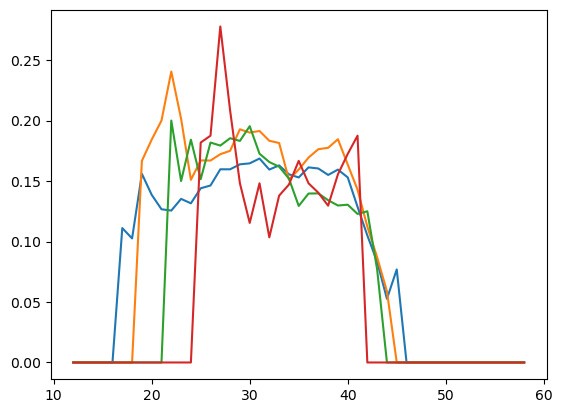

In [1690]:
plt.plot(age_list, ratio_list_0)
plt.plot(age_list, ratio_list_1)
plt.plot(age_list, ratio_list_2)
plt.plot(age_list, ratio_list_3)

In [1691]:
# Quadratic interpolation of the curves.
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d

age_obs = np.array(age_list)
age_inter = np.linspace(age_obs.min(), age_obs.max(), num = 10000)

ratio_obs_0 = np.array(ratio_list_0)
inter_0 = interpolate.interp1d(age_obs, ratio_obs_0, kind = "slinear")

ratio_obs_1 = np.array(ratio_list_1)
inter_1 = interpolate.interp1d(age_obs, ratio_obs_1, kind = "slinear")

ratio_obs_2 = np.array(ratio_list_2)
inter_2 = interpolate.interp1d(age_obs, ratio_obs_2, kind = "slinear")

ratio_obs_3 = np.array(ratio_list_3)
inter_3 = interpolate.interp1d(age_obs, ratio_obs_3, kind = "slinear")

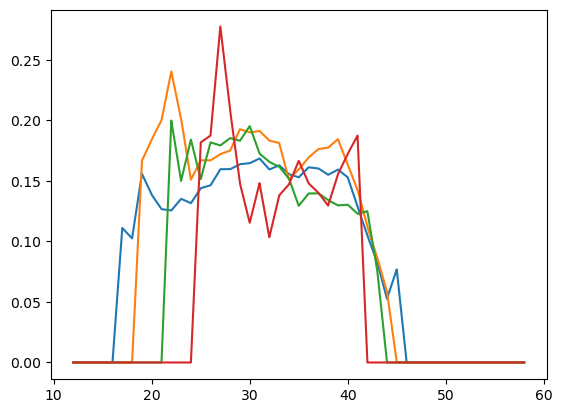

In [1692]:
plt.plot(age_inter, inter_0(age_inter))
plt.plot(age_inter, inter_1(age_inter))
plt.plot(age_inter, inter_2(age_inter))
plt.plot(age_inter, inter_3(age_inter))

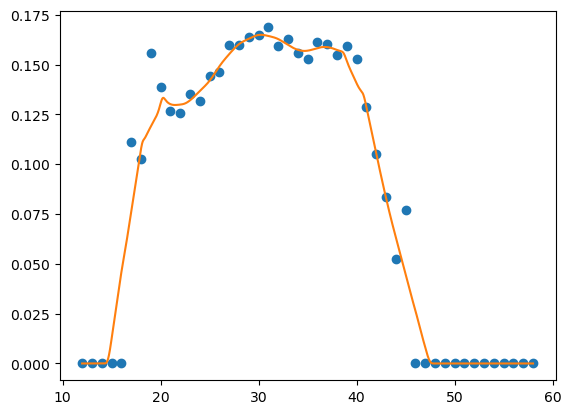

In [1693]:
# LOWESS smoother (locally weighted scatterplot smoothing). Local regression method.
# https://www.statsmodels.org/dev/examples/notebooks/generated/lowess.html#LOWESS-Smoother

lowess_0 = sm.nonparametric.lowess(inter_0(age_inter), age_inter, frac = 0.1)
lowess_0 = interpolate.interp1d(lowess_0[:, 0], lowess_0[:, 1], kind = "slinear")

plt.plot(age_obs, ratio_obs_0, "o", label="observation")
plt.plot(age_inter, lowess_0(age_inter))

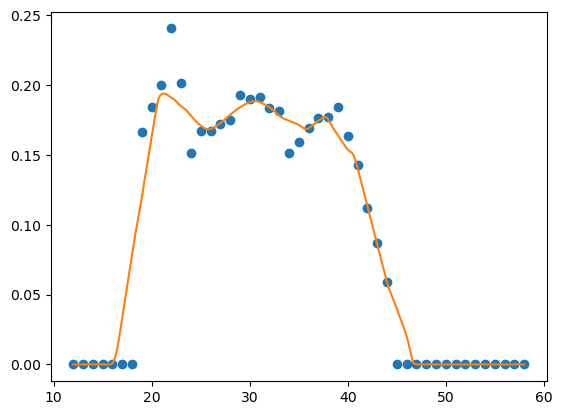

In [1694]:
# LOWESS smoother (locally weighted scatterplot smoothing). Local regression method.
lowess_1 = sm.nonparametric.lowess(inter_1(age_inter), age_inter, frac = 0.13)
lowess_1 = interpolate.interp1d(lowess_1[:, 0], lowess_1[:, 1], kind = "slinear")

plt.plot(age_obs, ratio_obs_1, "o", label="observation")
plt.plot(age_inter, lowess_1(age_inter))

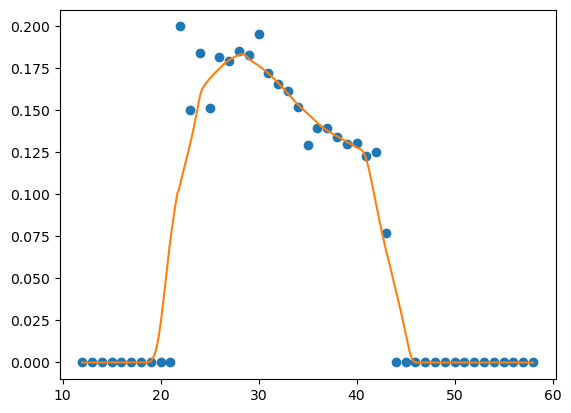

In [1695]:
# LOWESS smoother (locally weighted scatterplot smoothing). Local regression method.
lowess_2 = sm.nonparametric.lowess(inter_2(age_inter), age_inter, frac = 0.13)
lowess_2 = interpolate.interp1d(lowess_2[:, 0], lowess_2[:, 1], kind = "slinear")

plt.plot(age_obs, ratio_obs_2, "o", label="observation")
plt.plot(age_inter, lowess_2(age_inter))

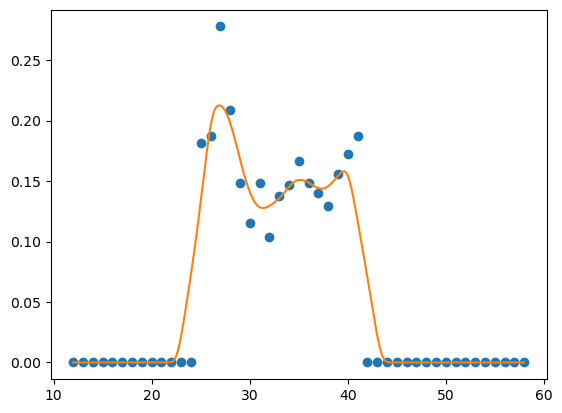

In [1696]:
# LOWESS smoother (locally weighted scatterplot smoothing). Local regression method.
lowess_3 = sm.nonparametric.lowess(inter_3(age_inter), age_inter, frac = 0.13)
lowess_3 = interpolate.interp1d(lowess_3[:, 0], lowess_3[:, 1], kind = "slinear")

plt.plot(age_obs, ratio_obs_3, "o", label="observation")
plt.plot(age_inter, lowess_3(age_inter))

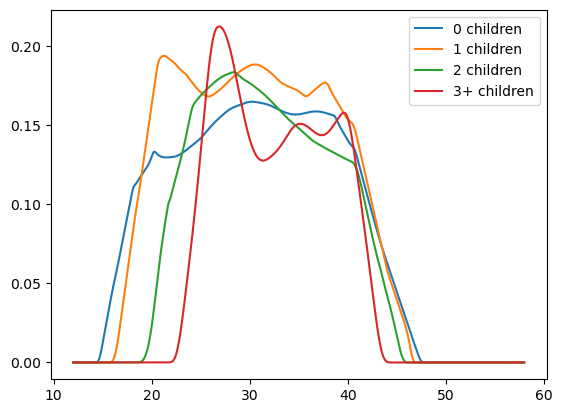

In [1697]:
plt.plot(age_inter, lowess_0(age_inter), label = "0 children")
plt.plot(age_inter, lowess_1(age_inter), label = "1 children")
plt.plot(age_inter, lowess_2(age_inter), label = "2 children")
plt.plot(age_inter, lowess_3(age_inter), label = "3+ children")
plt.legend()

In [1698]:
# Calculate P(child | VoC) 

# Create dataframes per wave change.
voc_1 = diff_1[["value_children", "birth", "intention"]].reset_index(drop = True)
voc_2 = diff_2[["value_children", "birth", "intention"]].reset_index(drop = True)
voc_4 = diff_4[["value_children", "birth", "intention"]].reset_index(drop = True)
voc_6 = diff_6[["value_children", "birth", "intention"]].reset_index(drop = True)

# Concatenate dataframes.
voc_total = pd.concat([voc_1, voc_2])
voc_total = pd.concat([voc_total, voc_4])
voc_total = pd.concat([voc_total, voc_6])

In [1699]:
voc_list = []
ratio_voc_list = []

for voc in np.linspace(voc_total["value_children"].min(), voc_total["value_children"].max(), 201):
    voc_list.append(voc)
    ratio_voc_list.append(rolling_ratio_voc(voc_total, voc, 0.15))

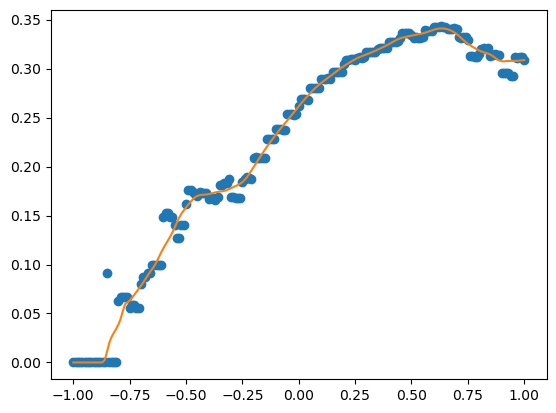

In [1700]:
plt.plot(voc_list, ratio_voc_list, "o")

# LOWESS smoother (locally weighted scatterplot smoothing). Local regression method.
lowess_voc = sm.nonparametric.lowess(ratio_voc_list, voc_list, frac = 0.1)
lowess_voc = interpolate.interp1d(lowess_voc[:, 0], lowess_voc[:, 1], kind = "slinear")

plt.plot(voc_list, lowess_voc(voc_list))

In [1701]:
# Filter out respondents without partners.
agents_1 = filter_rel(pf_1)
agents_2 = pf_2
agents_3 = pf_3
agents_4 = pf_4
agents_5 = pf_5
agents_6 = pf_6
agents_7 = pf_7
agents_8 = pf_8

In [1702]:
# Get only those anchors that continue with same partner in wave 8 from wave 1.
agents_1 = agents_1[agents_1["pid"].isin(agents_8["pid"])]
agents_2 = agents_2[agents_2["id"].isin(agents_1["id"])]
agents_3 = agents_3[agents_3["id"].isin(agents_1["id"])]
agents_4 = agents_4[agents_4["id"].isin(agents_1["id"])]
agents_5 = agents_5[agents_5["id"].isin(agents_1["id"])]
agents_6 = agents_6[agents_6["id"].isin(agents_1["id"])]
agents_7 = agents_7[agents_7["id"].isin(agents_1["id"])]
agents_8 = agents_8[agents_8["id"].isin(agents_1["id"])]

In [1703]:
# Set of IDs present in all waves. 
id_1 = set(agents_1["id"])
id_2 = set(agents_2["id"])
id_3 = set(agents_3["id"])
id_4 = set(agents_4["id"])
id_5 = set(agents_5["id"])
id_6 = set(agents_6["id"])
id_7 = set(agents_7["id"])
id_8 = set(agents_8["id"])
id_inter = id_1.intersection(id_2, id_3, id_4, id_5, id_6, id_7, id_8)

In [1704]:
# Get only those anchors that continue with same partner in wave 8 from wave 1.
agents_1 = agents_1[agents_1["id"].isin(id_inter)]
agents_2 = agents_2[agents_2["id"].isin(id_inter)]
agents_3 = agents_3[agents_3["id"].isin(id_inter)]
agents_4 = agents_4[agents_4["id"].isin(id_inter)]
agents_5 = agents_5[agents_5["id"].isin(id_inter)]
agents_6 = agents_6[agents_6["id"].isin(id_inter)]
agents_7 = agents_7[agents_7["id"].isin(id_inter)]
agents_8 = agents_8[agents_8["id"].isin(id_inter)]

In [1705]:
# Create new variables for simulation.
agents_1 = create_value_children(agents_1)
agents_1 = create_emotional_autonomy(agents_1)

agents_2 = create_value_children(agents_2)
agents_2 = create_social_pressure(agents_2)
agents_2 = create_social_support(agents_2)

agents_4 = create_value_children(agents_4)
agents_4 = create_social_pressure(agents_4)
agents_4 = create_social_support(agents_4)

agents_5 = create_emotional_autonomy(agents_5)

agents_6 = create_value_children(agents_6)
agents_6 = create_social_pressure(agents_6)
agents_6 = create_social_support(agents_6)

agents_8 = create_value_children(agents_8)

In [1706]:
# Get only interesting variables for simulation.
vars_gen = [
    "id", 
    "pid", 
    "wave",
    "age", 
    "page", 
    "sex_gen",
    "psex_gen",
    "nkidsbio", 
]

agents_1 = agents_1[vars_gen + ["value_children", "emotional_autonomy"]]
agents_2 = agents_2[vars_gen + ["value_children", "social_pressure", "social_support"]]
agents_3 = agents_3[vars_gen]
agents_4 = agents_4[vars_gen + ["value_children", "social_pressure", "social_support"]]
agents_5 = agents_5[vars_gen + ["emotional_autonomy"]]
agents_6 = agents_6[vars_gen + ["value_children", "social_pressure", "social_support"]]
agents_7 = agents_7[vars_gen]
agents_8 = agents_8[vars_gen + ["value_children"]]

In [1707]:
# Change columns to numeric.
cols = ["wave", "sex_gen", "psex_gen"]

agents_1[cols] = convert_items_num(agents_1[cols])
agents_2[cols] = convert_items_num(agents_2[cols])
agents_3[cols] = convert_items_num(agents_3[cols])
agents_4[cols] = convert_items_num(agents_4[cols])
agents_5[cols] = convert_items_num(agents_5[cols])
agents_6[cols] = convert_items_num(agents_6[cols])
agents_7[cols] = convert_items_num(agents_7[cols])
agents_8[cols] = convert_items_num(agents_8[cols])

In [1708]:
# Initial set of agents.
agents_initial = agents_1.copy()
agents_initial["social_pressure"] = agents_2["social_pressure"].values
agents_initial["social_support"] = agents_2["social_support"].values
agents_initial = agents_initial.iloc[agents_initial.isnull().sum(axis=1).argsort()][1:1301]

In [1709]:
# KNN imputation of missing values.
# https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer

# Define KNN model.
imputer = KNNImputer(
    n_neighbors = 5,
    weights = "uniform",
    metric = "nan_euclidean"
)

# Fit on data.
imputer.fit(agents_initial.drop(["id", "pid", "wave"], axis = 1))

# Replace data.
imputer.set_output(transform = "pandas")
agents_impute = imputer.transform(agents_initial.drop(["id", "pid", "wave"], axis = 1))

# Make sure Int variables stay that way.
agents_impute["age"] = agents_impute["age"].apply(lambda x: int(round(x, 0)))
agents_impute["page"] = agents_impute["page"].apply(lambda x: int(round(x, 0)))
agents_impute["sex_gen"] = agents_impute["sex_gen"].apply(lambda x: int(round(x, 0)))
agents_impute["psex_gen"] = agents_impute["psex_gen"].apply(lambda x: int(round(x, 0)))
agents_impute["num_kids"] = agents_impute["nkidsbio"].apply(lambda x: int(round(x, 0)))

# Round to 2 decimals.
agents_impute["social_pressure"] = agents_impute["social_pressure"].apply(lambda x: round(x, 2))
agents_impute["social_support"] = agents_impute["social_support"].apply(lambda x: round(x, 2))

# Replace old NaN values with imputed ones.
agents_initial[list(agents_impute.columns)] = agents_impute

In [1710]:
# Focus on the initial agents
agents_1 = agents_1[agents_1["id"].isin(agents_initial["id"])]
agents_2 = agents_2[agents_2["id"].isin(agents_initial["id"])]
agents_3 = agents_3[agents_3["id"].isin(agents_initial["id"])]
agents_4 = agents_4[agents_4["id"].isin(agents_initial["id"])]
agents_5 = agents_5[agents_5["id"].isin(agents_initial["id"])]
agents_6 = agents_6[agents_6["id"].isin(agents_initial["id"])]
agents_7 = agents_7[agents_7["id"].isin(agents_initial["id"])]
agents_8 = agents_8[agents_8["id"].isin(agents_initial["id"])]

In [1711]:
# Create births for all years.
diff_1 = create_births(agents_1, agents_2)
diff_2 = create_births(agents_2, agents_3)
diff_3 = create_births(agents_3, agents_4)
diff_4 = create_births(agents_4, agents_5)
diff_5 = create_births(agents_5, agents_6)
diff_6 = create_births(agents_6, agents_7)
diff_7 = create_births(agents_7, agents_8)

In [1726]:
# Count number of births after each wave.
births_per_wave = pd.DataFrame({
    "wave": [1, 2, 3, 4, 5, 6, 7], 
    "births": [
        diff_1["birth"].sum(),
        diff_2["birth"].sum(),
        diff_3["birth"].sum(),
        diff_4["birth"].sum(),
        diff_5["birth"].sum(),
        diff_6["birth"].sum(),
        diff_7["birth"].sum()
    ]
})

num_kids = int(diff_1["nkidsbio"].sum())

num_kids_t =  [num_kids]

for births in births_per_wave["births"].values:

    num_kids += int(births)
    num_kids_t.append(num_kids)

ref_num_kids = pd.DataFrame({
    "t": list(range(8)),
    "num_kids_total": num_kids_t
})

ref_num_kids = ref_num_kids.set_index("t")

ref_num_kids

,num_kids_total
t,
0,1493
1,1634
2,1764
3,1885
4,1996
5,2107
6,2212
7,2284


In [1419]:
# Select the woman's age in all cases.
agents_initial = select_age(agents_initial)

# Set social pressure as binary.
agents_initial["social_pressure"] = agents_initial["social_pressure"].apply(lambda x: 1 if x > 0 else -1)

In [1420]:
# Get only the necessary variables.
agents_params = agents_initial.drop(["id", "pid", "wave", "page", "sex_gen", "psex_gen", "nkidsbio"], axis = 1).reset_index(drop = True)

# Save to CSV.
agents_params.to_csv("../data/processed/fert_agents_params.csv", index = False)

In [1421]:
agents_params

,age,value_children,emotional_autonomy,social_pressure,social_support,num_kids
0,35,0.55,0.92,-1,0.25,2
1,26,0.20,0.67,1,0.75,1
2,31,0.45,0.83,-1,0.58,4
3,42,0.35,0.83,1,0.67,0
4,37,0.05,0.75,-1,0.25,3
...,...,...,...,...,...,...
1295,30,0.55,0.67,1,0.70,1
1296,33,0.55,0.83,-1,0.37,3
1297,36,0.85,1.00,-1,0.60,3
1298,26,-0.10,0.75,1,0.62,0


## Model Definition

We define a new agent type called `Couple` by creating a subclass of `Agent`.

In [1614]:
# Probabilities.
probs = {
    "kids_0": lowess_0,
    "kids_1": lowess_1,
    "kids_2": lowess_2,
    "kids_3": lowess_3,
    "value_children": lowess_voc 
}

In [1423]:
def prob_age_num_kids(age, num_kids):
    """ Probability of having a kid depending on age and previous children. """

    if num_kids == 0:
        return float(lowess_0(age))
    elif num_kids == 1:
        return float(lowess_1(age))
    elif num_kids == 2:
        return float(lowess_2(age))
    else:
        return float(lowess_3(age))

In [1424]:
def prob_value_children(value_children):
    """ Probability of having a kid depending on the value of children. """

    return float(lowess_voc(value_children))

In [1838]:
class Couple(ap.Agent): 

    def setup(
        self, 
        age, 
        value_children, 
        emotional_autonomy, 
        social_pressure, 
        social_support, 
        num_kids
    ):
        """ Initialize a new variable at agent creation. """

        # Personal variables of each couple.

        # Agent's beliefs, B:
        self.age = age
        self.num_kids = num_kids
        self.social_pressure = social_pressure
        self.social_support = social_support

        # Agent's desires, D:
        self.value_children = value_children
        self.emotional_autonomy = emotional_autonomy

        # Intention of having a child, I = {0, 1}.
        self.intention =  0


    def deliberate(self, probs):
        """ Deliberation: decide whether to have a kid or not. """

        # Random number generator.
        rng = self.model.random

        # Calculate probability.
        probability = float(probs["value_children"](self.value_children))

        # Value of Children.
        VoC = self.value_children

        # calculate willing.
        willing = probability > rng.random()

        # Calculate supported.
        supported = self.social_support >= self.p.th_S

        # Social pressure.
        p_plus = self.social_pressure == 1
        p_minus = self.social_pressure == -1

        # Emotional autonomy.
        EA = self.emotional_autonomy >= self.p.th_EA

        # Reset intention, I.
        self.intention = 0

        # If Value of Children is Max, always intend to have children.
        if VoC == 1:
            self.intention = 1

        # If the agent is indifferent, it complies with the group opinion of its network.
        elif VoC == 0 and p_plus:
            self.intention = 1

        # If the agent is willing, it will intend to have a child as long as its social network 
        # has a positive opinion toward children or it has enough emotional autonomy to resist child-averse social pressure.
        elif VoC > 0 and willing and (p_plus or EA):
            self.intention = 1

        # An unwilling agent can be convinced to have a children if its EA is low.
        elif VoC > -1 and not willing and p_plus and not EA:
            self.intention = 1

        # A willing agent pressured against having children counterbalances that with social support.
        elif VoC > 0 and willing and p_minus and not EA and supported:
            self.intention = 1

        elif VoC > 0 and not willing and (p_minus or EA) and supported:
            self.intention = 1

        else:
            self.intention = 0


    def action(self, probs):
        """ Action: have a kid depending on Intention and probability. """

        if self.intention == 1:

            if self.num_kids == 0:
                probability = float(probs["kids_0"](self.age))
            
            elif self.num_kids == 1:
                probability = float(probs["kids_1"](self.age))
            
            elif self.num_kids == 2:
                probability = float(probs["kids_2"](self.age))
            
            else:
                probability = float(probs["kids_3"](self.age))

        else:

            probability = 0.0

        rng = self.model.random
        
        if probability > rng.random():

            # Have a kid.
            self.num_kids += 1

    def update_pressure(self):
        """ Update social pressure according to neighbors. """

        neighbors_social_pressure = []

        for n in self.network.neighbors(self):

            neighbors_social_pressure.append(n.social_pressure)

        mean_pressure = np.mean(neighbors_social_pressure)

        if (mean_pressure > 0) and (abs(self.value_children < abs(mean_pressure))):

            self.social_pressure = 1

        elif (mean_pressure < 0) and (abs(self.value_children < abs(mean_pressure))):

            self.social_pressure = -1
        
        else:

            None

In [1839]:
class FertModel(ap.Model):
    """ A simple fertility contagion model. """

    def setup(
        self, 
        age, 
        value_children, 
        emotional_autonomy, 
        social_pressure, 
        social_support, 
        num_kids, 
        probs, 
        ref_num_kids
    ):
        
        # Create agents with empirical parameters.
        self.agents = ap.AgentList(
            model = self, 
            objs = self.p.agents, 
            cls = Couple, 
            age = ap.AttrIter(age),
            value_children = ap.AttrIter(value_children),
            emotional_autonomy = ap.AttrIter(emotional_autonomy),
            social_pressure = ap.AttrIter(social_pressure),
            social_support = ap.AttrIter(social_support),
            num_kids = ap.AttrIter(num_kids)
        )

        # Prepare a small-world Watts-Strogatz network graph.
        graph = nx.watts_strogatz_graph(
            self.p.agents,
            self.p.number_of_neighbors,
            self.p.network_randomness
        )

        # Create network.
        self.network = self.agents.network = ap.Network(self, graph)

        # Add agents as nodes of the network.
        self.network.add_agents(self.agents, self.network.nodes)

        # Add extra model parameters.
        self.probs = probs
        self.ref_num_kids = ref_num_kids

    def step(self):

        self.agents.update_pressure()
        self.agents.deliberate(self.probs)
        self.agents.action(self.probs)

    def update(self):

        self["num_kids_total"] = np.sum(np.array(self.agents.num_kids))
        self.record("num_kids_total", np.sum(np.array(self.agents.num_kids)))

    def end(self):

        self.report("Error", np.linalg.norm(np.array(self.log["num_kids_total"]) - np.array(self.ref_num_kids)))

In [1840]:
parameters = {
    "agents": len(agents_params),
    "steps": 7,
    "number_of_neighbors": 3,
    "network_randomness": 0.5,
    "th_EA": 0.9,
    "th_S": 0.9
}

model = FertModel(
    parameters,
    age = agents_params["age"].values,
    value_children = agents_params["value_children"].values,
    emotional_autonomy = agents_params["emotional_autonomy"].values,
    social_pressure = agents_params["social_pressure"].values,
    social_support = agents_params ["social_support"].values,
    num_kids = agents_params["num_kids"].values,
    probs = probs,
    ref_num_kids = ref_num_kids["num_kids_total"].values
)
results = model.run()

Completed: 7 steps
Run time: 0:00:00.487456
Simulation finished


## Multi-run Experiment

In [1843]:
# Define some parameters as ranges.
parameters = {
    "agents": len(agents_params),
    "steps": 7,
    "number_of_neighbors": ap.IntRange(2, 8),
    "network_randomness": ap.Range(0.0, 1.0),
    "th_EA": ap.Range(0.0, 1.0),
    "th_S": ap.Range(0.0, 1.0),
}

# Create a sample with all possible combinations of parameters.
sample = ap.Sample(
    parameters,
    n = 128,
    method = "saltelli",
    calc_second_order = False
)

# Create an experiment that runs the model over all parameter combinations.
# Ten random iterations per combination.
experiment = ap.Experiment(
    FertModel, 
    sample, 
    iterations = 10,
    age = agents_params["age"].values,
    value_children = agents_params["value_children"].values,
    emotional_autonomy = agents_params["emotional_autonomy"].values,
    social_pressure = agents_params["social_pressure"].values,
    social_support = agents_params ["social_support"].values,
    num_kids = agents_params["num_kids"].values,
    probs = probs,
    ref_num_kids = ref_num_kids["num_kids_total"].values
)
results = experiment.run()

Scheduled runs: 7680
Completed: 7680, estimated time remaining: 0:00:00
Experiment finished
Run time: 1:16:30.277306


array([[<Axes: title={'center': 'Error'}>]], dtype=object)

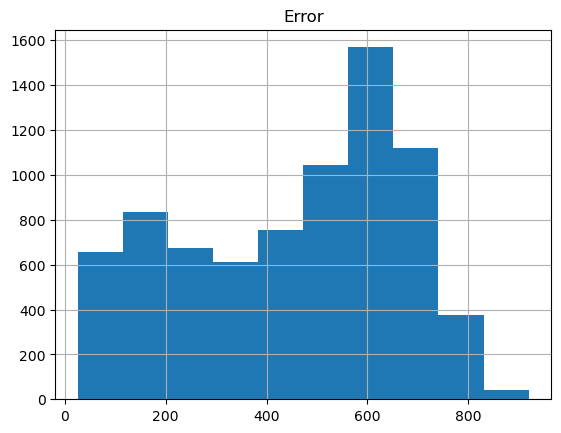

In [1888]:
results.reporters.hist()

## Sensitivity Analysis

In [1889]:
results.calc_sobol()

c:\Users\jperezv\AppData\Local\miniforge3\envs\multisim\Lib\site-packages\agentpy\datadict.py:148: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  reporters_df = self.reporters.groupby('sample_id').mean()


DataDict {
'info': Dictionary with 12 keys
'parameters': 
    'constants': Dictionary with 2 keys
    'sample': DataFrame with 4 variables and 768 rows
    'log': Dictionary with 5 keys
'reporters': DataFrame with 2 variables and 7680 rows
'sensitivity': 
    'sobol': DataFrame with 2 variables and 4 rows
    'sobol_conf': DataFrame with 2 variables and 4 rows
}

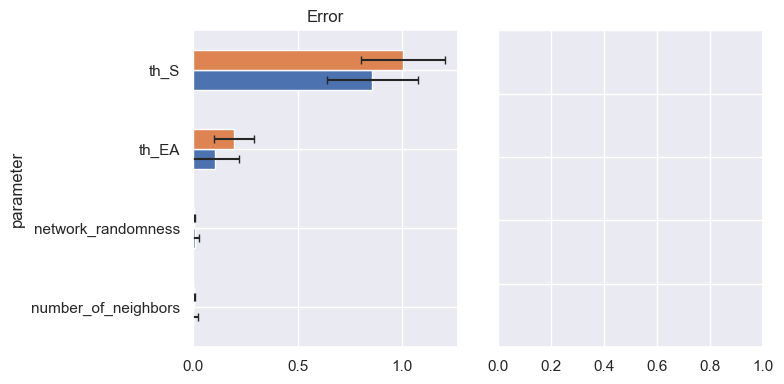

In [1893]:
# Use Pandas to create a bar plot for the sensitivity indices.
def plot_sobol(results):
    """ Bar plot of Sobol sensitivity indices. """

    sns.set()
    fig, axs = plt.subplots(1, 2, figsize = (8, 4))
    si_list = results.sensitivity.sobol.groupby(by = "reporter")
    si_conf_list = results.sensitivity.sobol_conf.groupby("reporter")

    for (key, si), (_, err), ax in zip(si_list, si_conf_list, axs):

        si = si.droplevel("reporter")
        err = err.droplevel("reporter")
        si.plot.barh(xerr = err, title = key, ax = ax, capsize = 3)
        ax.set_xlim(0)

    axs[0].get_legend().remove()
    axs[1].set(ylabel = None, yticklabels = [])
    axs[1].tick_params(left = False)
    plt.tight_layout()

plot_sobol(results)

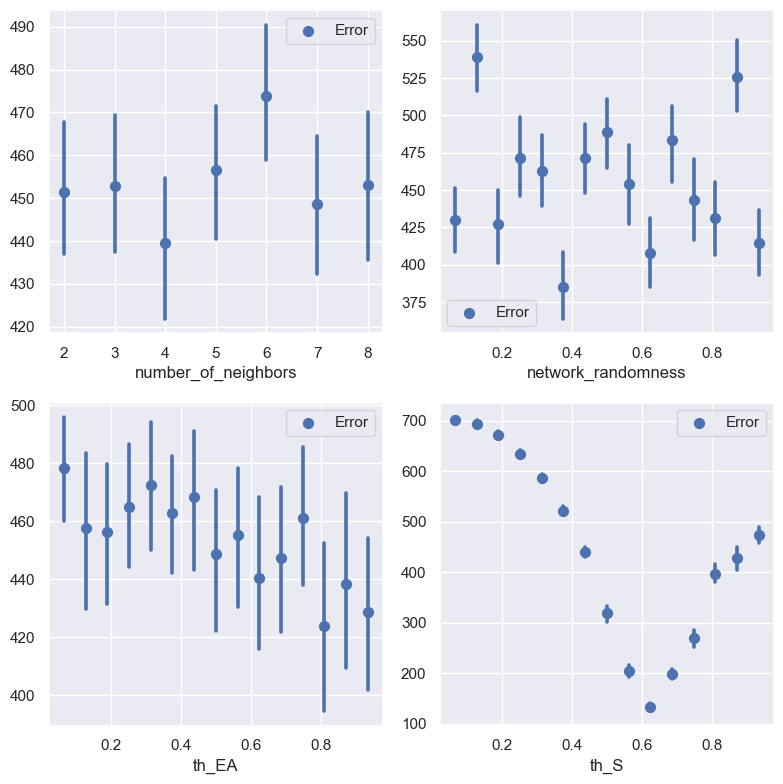

In [1895]:
# Average evaluation measures over parameter variations.
def plot_sensitivity(results):
    """ Show average simulation results for different parameter values. """

    sns.set()
    fig, axs = plt.subplots(2, 2, figsize = (8, 8))
    axs = [i for j in axs for i in j] # Flatten list.

    data = results.arrange_reporters().astype("float")
    params = results.parameters.sample.keys()

    for x, ax in zip(params, axs):

        for y in results.reporters.columns[1:]:
            
            sns.regplot(
                x = x,
                y = y,
                data = data, 
                ax = ax,
                ci = 99,
                x_bins = 15,
                fit_reg = False,
                label = y
            )

            ax.set_ylabel("")
            ax.legend()
    
    plt.tight_layout()

plot_sensitivity(results)

In [1914]:
results = ap.DataDict.load(path = "H:/Mi unidad/TFM/Repo/pairfam-multisim/notebooks/fert_output")

Loading from directory H:/Mi unidad/TFM/Repo/pairfam-multisim/notebooks/fert_output/FertModel_1/
Loading info.json - Successful
Loading parameters_constants.json - Successful
Loading parameters_sample.csv - Successful
Loading parameters_log.json - Successful
Loading reporters.csv - Successful


In [1948]:
# Get better runs and their parameters.
error_mean = results.reporters.mean(level = "sample_id").sort_values("Error").drop("seed", axis = 1)
best_runs = pd.DataFrame(sample).reset_index(names = "sample_id").merge(error_mean, on = "sample_id").sort_values("Error")
best_runs[0:10]

C:\Users\jperezv\AppData\Local\Temp\ipykernel_22676\3419299964.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  error_mean = results.reporters.mean(level = "sample_id").sort_values("Error").drop("seed", axis = 1)


,sample_id,agents,steps,number_of_neighbors,network_randomness,th_EA,th_S,Error
538,538,1300,7,6,0.605469,0.566406,0.628906,83.294626
297,297,1300,7,6,0.910156,0.097656,0.582031,84.466490
47,47,1300,7,7,0.800781,0.488281,0.621094,86.152794
235,235,1300,7,8,0.691406,0.621094,0.613281,86.352018
10,10,1300,7,5,0.832031,0.792969,0.746094,86.675327
702,702,1300,7,8,0.933594,0.457031,0.636719,86.950161
97,97,1300,7,6,0.175781,0.199219,0.597656,88.124210
236,236,1300,7,3,0.128906,0.621094,0.613281,88.157903
641,641,1300,7,3,0.636719,0.542969,0.582031,88.330556
156,156,1300,7,8,0.238281,0.511719,0.660156,89.427886


In [1995]:
parameters = {
    "agents": len(agents_params),
    "steps": 7,
    "number_of_neighbors": 6,
    "network_randomness": 0.6,
    "th_EA": 0.6,
    "th_S": 0.6
}

model = FertModel(
    parameters,
    age = agents_params["age"].values,
    value_children = agents_params["value_children"].values,
    emotional_autonomy = agents_params["emotional_autonomy"].values,
    social_pressure = agents_params["social_pressure"].values,
    social_support = agents_params ["social_support"].values,
    num_kids = agents_params["num_kids"].values,
    probs = probs,
    ref_num_kids = ref_num_kids["num_kids_total"].values
)
results_single = model.run()
results_single.reporters

Completed: 7 steps
Run time: 0:00:00.544637
Simulation finished


,seed,Error
0,41987014169509006307404591701382049847,86.666026


<Axes: xlabel='t'>

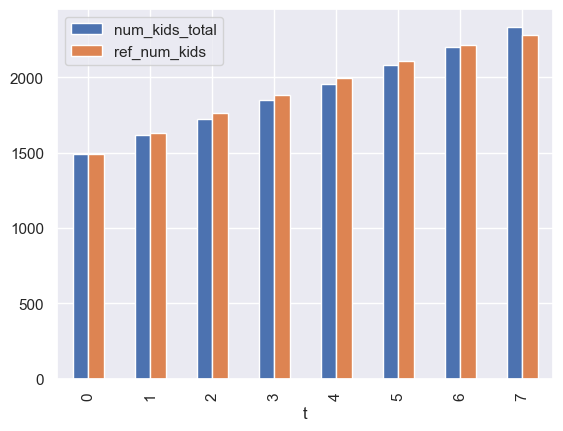

In [1996]:
results_df = results_single.variables.FertModel
results_df["ref_num_kids"] = ref_num_kids["num_kids_total"]
results_df.plot(kind = "bar")